## <span style="color:blue"> Computer Vision - Winter 2024

## <span style="color:blue"> Exercise 2 </span>
**Reichman University**

**Lecturer:** Prof. Yael Moses, RUNI

**TA:** Eyal Friedman, RUNI

**Submission date: 25.1.24** \
Note: In case you need an extension for any reason, you can submit it by 29.1.24. \
No extra extensions will be given.
In case you are in miluim - please contact Yael directly.

**Your name: [Your Name]**
**Your ID: [Your ID]**

In this exercise, you will implement: 
    
1. Straight line detection from image features using  Hough Transform.
2. Various feature matching.
3. Computing depth from rectified images.


## <span style="color:blue"> Submission guidelines:</span>

1. Your **zip** file should include the following files only:
   - ex2.ipynb
   - images you use that were not given 
2. You should use Jupyter Notebook.
3. Name the zip file **'ex2_ID_ID.zip'** and **do not** include any additional directories.
4. Submit using *Moodle*.
5. Submit on time!
6. You can submit this assignment in pairs (no triplets).
   * In the case of pair submission, both IDs and names should be added to the notebook.
   * One should submit the homework, and the other should submit a simple text file named: ID_ID.txt and nothing else.
   *Please make sure that your collaborator submits the HW.

## Read the following instructions carefully:

1. Write **efficient vectorized** code. When you think you cannot use vectorized code, give a short explanation of why.
2. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests unless requested.
3. Use `Python 3` and `numpy 1.18.5` or above. Changes to the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden unless provided by us.
5. Your code must run without errors. Note, **Code that fails to run will not be graded.**
6. Document your code properly.
7. Go over Warmup Python - you can find relevant python functions that will make your life easier.



## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the web (including ChatGPT), however, you will not learn what you should learn from it. In addition, since we give grades on the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solve the tasks. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.

## I declair that I respcet the honor code:
<span style="color:red"> Add here your names: 


In [1]:
import cv2
from matplotlib import pyplot as plt
# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')
import argparse
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
import timeit


# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.10.11
Numpy version:  1.23.5




## <span style="color:blue">Section A: Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$. 
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$. 






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions. 
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

In [2]:
def retain_max_in_neighborhood(matrix, radius):
    """
    Retain the maximum value in each neighborhood defined by a circular mask.
    """
    # Create a binary mask to define the circular neighborhood
    neighborhood_mask = np.zeros((2 * radius + 1, 2 * radius + 1), dtype=bool)
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    neighborhood_mask = x**2 + y**2 <= radius**2

    # Use scipy's maximum filter to get the local maximum in each circular neighborhood
    max_values = maximum_filter(matrix, footprint=neighborhood_mask)

    # Set all values to zero except for the maximum value in each neighborhood
    result = np.where(matrix == max_values, matrix, 0)

    return result

def show1Image(base):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(base)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.yaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.25)

def show2Images(base, conv):
    f = plt.figure()
    f.set_figwidth(15)
    plt.tight_layout()
    f.add_subplot(1, 2, 1)
    plt.imshow(base)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.yaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.25)
    f.add_subplot(1, 2, 2)
    plt.imshow(conv)

    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.yaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.25)
    plt.show(block=True)

def show3Images(img1, img2, img3):
        
    # Create a figure
    fig = plt.figure()  # Adjust the figsize as needed

    # Add three subplots in a horizontal layout
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    # Plot the images in the subplots
    ax1.imshow(img1, cmap='gray')  # Replace 'gray' with the desired colormap
    ax1.grid(which='major', linestyle='--', linewidth=0.5)
    ax1.grid(which='minor', linestyle='--', linewidth=0.25)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))
    ax1.yaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))

    ax2.imshow(img2, cmap='gray')
    ax2.grid(which='major', linestyle='--', linewidth=0.5)
    ax2.grid(which='minor', linestyle='--', linewidth=0.25)
    ax2.xaxis.tick_top()
    ax2.xaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))
    ax2.yaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))

    ax3.imshow(img3, cmap='gray')
    ax3.grid(which='major', linestyle='--', linewidth=0.5)
    ax3.grid(which='minor', linestyle='--', linewidth=0.25)
    ax3.xaxis.tick_top()
    ax3.xaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))
    ax3.yaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the figure
    plt.show()

In [31]:

def H_matrix(L_points, resolution_r, resolution_ang):
    height, width = L_points.shape[:2]
    diag_len = np.sqrt(np.square(height) + np.square(width))
    thetas = np.arange(0, 180, step=resolution_ang)
    rhos = np.arange(-diag_len, diag_len, step=resolution_r)
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))

    accumulator = np.zeros((len(rhos), len(thetas)))
    hough_rhos_cumulative = []

    for y in range(height):
        for x in range(width):
            if L_points[y][x] != 0:  # white pixel
                edge_pt = [y - height / 2, x - width / 2]
                hough_rhos, hough_thetas = [], []
                for theta_idx in range(len(thetas)):
                    rho = (edge_pt[1] * cos_thetas[theta_idx]) + (edge_pt[0] * sin_thetas[theta_idx])
                    theta = thetas[theta_idx]
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1
                    hough_rhos.append(rho)
                    hough_thetas.append(theta)
                hough_rhos_cumulative.append(hough_rhos)
    return accumulator, thetas, rhos, hough_rhos_cumulative

def H_matrix_vec(L_points, resolution_r=1, resolution_ang=1):
    height, width = L_points.shape[:2]
    max_diag = np.sqrt(np.square(height) + np.square(width))
    thetas_range = np.arange(0, 180, step=resolution_ang)
    rhos_range = np.arange(-max_diag, max_diag, step=resolution_r)
    cos_thetas_range = np.cos(np.deg2rad(thetas_range))
    sin_thetas_range = np.sin(np.deg2rad(thetas_range))
    accumulator = np.zeros((len(rhos_range), len(rhos_range)))
    edge_points = np.argwhere(L_points != 0)
    edge_points = edge_points - np.array([[height/2, width/2]])

    rho_values = np.matmul(edge_points, np.array([sin_thetas_range, cos_thetas_range]))
    flat_rho_values = rho_values.flatten()
    thetas_range_2d = np.tile(thetas_range, rho_values.shape[0])

    accumulator, theta_vals, rho_vals = np.histogram2d(thetas_range_2d,flat_rho_values,bins=[thetas_range, rhos_range])
    accumulator = np.transpose(accumulator)

    return accumulator,thetas_range, rhos_range, rho_values


def list_lines(H, th, img_shape, rhos, thetas):
    # th - number of minimal points on the line
    out_lines = []
    for y in range(H.shape[0]):
        for x in range(H.shape[1]):
            # If number of votes is greater than bin_threshold provided shortlist it as a candidate line
            if H[y][x] > th:
                rho = rhos[y]
                theta = thetas[x]

                # a and b are intercepts in x and y direction
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))

                x0 = (a * rho) + img_shape[1] / 2
                y0 = (b * rho) + img_shape[0] / 2

                # Get the extreme points to draw the line
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                out_lines.append((rho, theta, x1, y1, x2, y2))
    return out_lines

def list_lines_vec(H, th, img_shape, rhos, thetas):
    # th - number of minimal points on the line
    y_coords, x_coords = np.where(H > th)
    
    # Calculate corresponding rho and theta values
    rhos_selected = rhos[y_coords]
    thetas_selected = thetas[x_coords]

    # a and b are intercepts in x and y direction
    a = np.cos(np.deg2rad(thetas_selected))
    b = np.sin(np.deg2rad(thetas_selected))

    x0 = (a * rhos_selected) + img_shape[1] / 2
    y0 = (b * rhos_selected) + img_shape[0] / 2

    # Get the extreme points to draw the line
    x1 = (x0 + 1000 * (-b)).astype(int)
    y1 = (y0 + 1000 * (a)).astype(int)
    x2 = (x0 - 1000 * (-b)).astype(int)
    y2 = (y0 - 1000 * (a)).astype(int)

    out_lines = list(zip(rhos_selected, thetas_selected, x1, y1, x2, y2))
    return out_lines


def display_lines(im, list_lines):
    output_img = im.copy()
    for line in list_lines:
        output_img = cv2.line(output_img, (line[2], line[3]), (line[4], line[5]), (255,0, 0), 1)
    plt.imshow(output_img)
    plt.show()

def display_image_line_image(im, lines):
    plt.figure(figsize=(8, 8))
    plt.suptitle('Hough Line Detection', fontsize=16)

    plt.subplot(221)
    plt.imshow(im)
    plt.title('Original Image')

    image_with_lines = im.copy()
    for line in lines:
        cv2.line(image_with_lines, (line[2], line[3]), (line[4], line[5]), (255, 0, 0), 2)

    plt.subplot(222)
    plt.imshow(image_with_lines)
    plt.title('Image with Detected Lines')
    plt.tight_layout()
    plt.show()



5


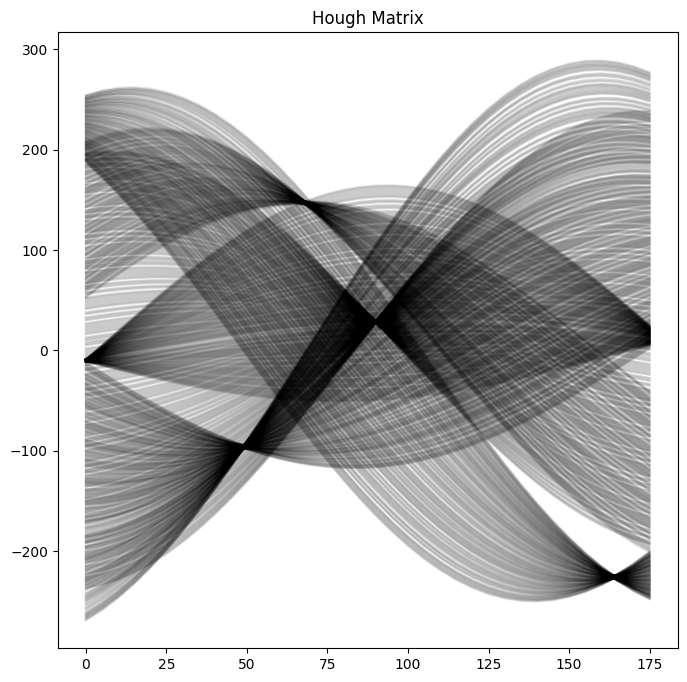

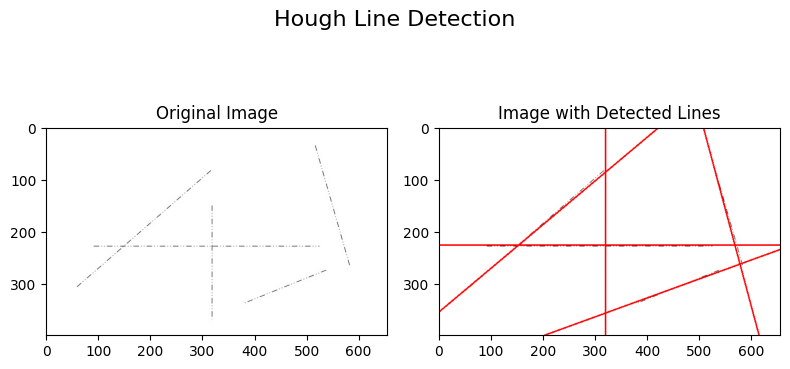

6


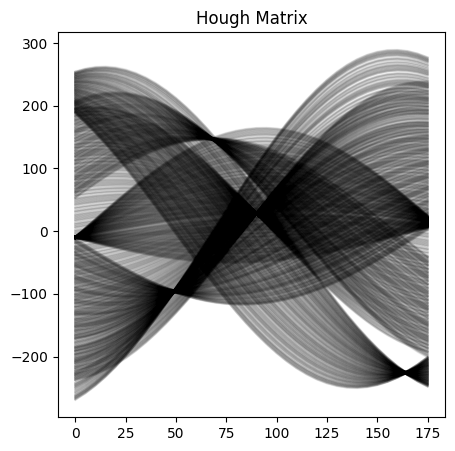

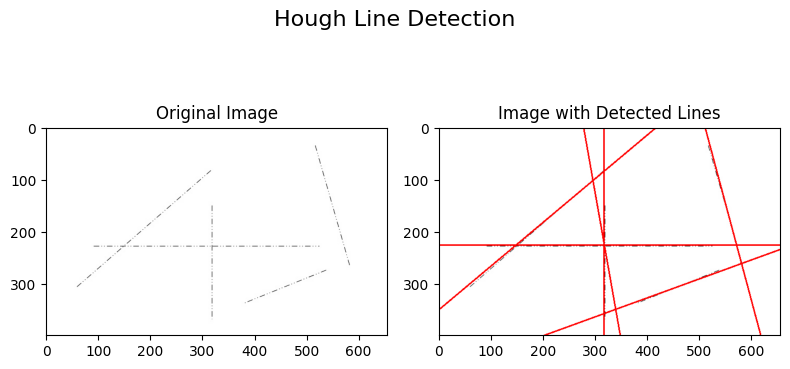

In [35]:
def edge_detection(input_img, threshold1=100, threshold2=200):
    edge_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    edge_image = cv2.GaussianBlur(edge_image,(3,3),0)
    edge_image = cv2.Canny(edge_image, threshold1, threshold2)
    return edge_image


def straight_lines(image_file, res_rho, res_ang,min_number_points,display=False, max_radius=False):
    input_img = cv2.imread(image_file)
    # Edge detection on the input image
    edge_image = edge_detection(input_img)
    accumulator, thetas, rhos, cu_rhos = H_matrix(edge_image, res_rho, res_ang)
    if max_radius: accumulator = retain_max_in_neighborhood(accumulator, 4)
    lines = list_lines(accumulator, min_number_points, edge_image.shape, rhos, thetas)
    print(len(lines))

    if display:
        # display_lines(input_img, lines)
        cu_rhos = np.array(cu_rhos)
        figure = plt.figure(figsize=(8, 8))
        hough_plot = figure.add_subplot()
        # hough_plot.set_facecolor((0, 0, 0))
        # hough_plot.invert_yaxis()
        hough_plot.title.set_text("Hough Matrix")
        hough_plot.plot(thetas, cu_rhos.T, color="black", alpha=0.05)

        display_image_line_image(input_img, lines)

    return lines

def straight_lines2(image_file, res_rho, res_ang,min_number_points,display=False, max_radius=False):
    input_img = cv2.imread(image_file)
    # Edge detection on the input image
    edge_image = edge_detection(input_img)
    accumulator, thetas, rhos, cumul_rhos = H_matrix_vec(edge_image, res_rho, res_ang)
    if max_radius: accumulator = retain_max_in_neighborhood(accumulator, 4)
    lines = list_lines_vec(accumulator, min_number_points, edge_image.shape, rhos, thetas)
    print(len(lines))

    if display:
        # display_lines(input_img, lines)
        cumul_rhos = np.array(cumul_rhos)
        figure = plt.figure(figsize=(5, 5))
        # figure = plt.figure()
        hough_plot = figure.add_subplot()
        # hough_plot.set_facecolor((0, 0, 0))
        # hough_plot.invert_yaxis()
        hough_plot.title.set_text("Hough Matrix")
        hough_plot.plot(thetas, cumul_rhos.T, color="black", alpha=0.05)
        display_image_line_image(input_img, lines)

    return lines

imgpath = 'lines1.jpg'
resolution_r = 3
resolution_ang = 5
bin_threshold = 100
lines_are_white = True

straight_lines(imgpath, resolution_r, resolution_ang, bin_threshold,  True, True)
straight_lines2(imgpath, resolution_r, resolution_ang, bin_threshold,  True, True)
print()

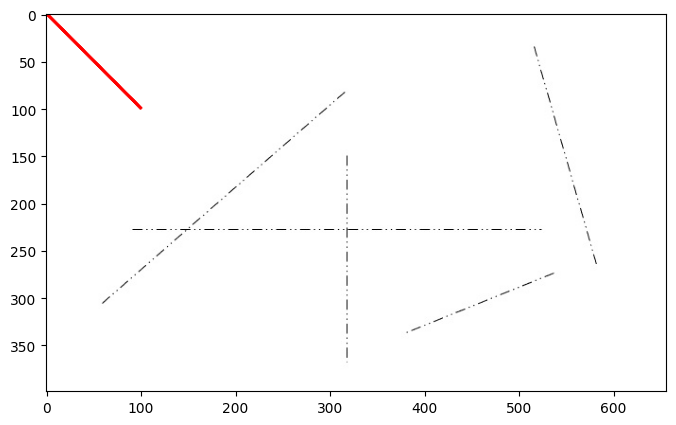

In [5]:
# Here is an example of how to draw a red line
# between (x1, y1) and (x2, y2) on a gray level image, img
# The first step is to create a color image from img.
img = cv2.imread(imgpath)
x1, y1, x2, y2 = 0, 0, 100, 100
thickness = 2
imC=np.dstack([img,img,img])   # a gray level image that is saved as a color image
cv2.line(img, (x1, y1), (x2, y2), (255,0,0), thickness)
imgplot = plt.imshow(img)


(<matplotlib.image.AxesImage at 0x1818e8539d0>, Text(0.5, 1.0, 'Edge Image'))

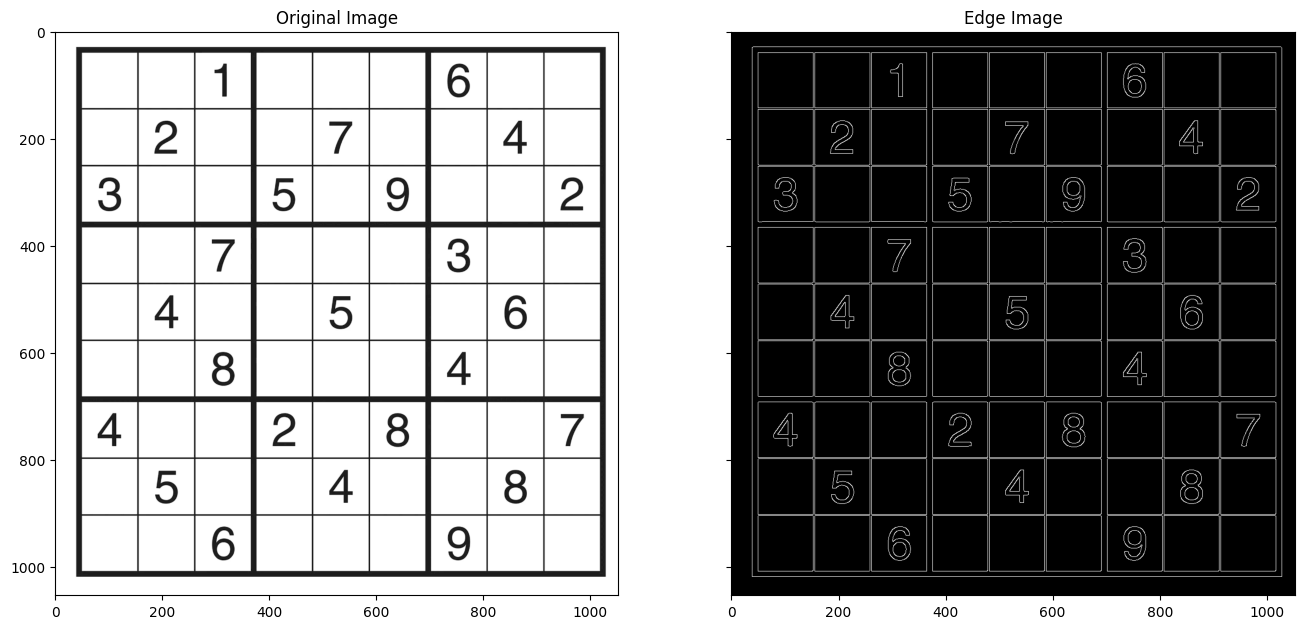

In [6]:
# Here is an example of how to use the CV2 Canny edge detector.
# You can play with the parameters to achieve desired results.
# Note that this implementation does not include smoothing with a Gaussian filter :(


img = cv2.imread('.\images\Sudoku.PNG', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,250,500,5)

plt.rcParams['figure.figsize'] = (16.0, 16.0) 
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')


**Apply and answer**

1. Generate a synthetic image to test your Hough Transform algorithm. 
   * Submit the image as well as the results.


2. Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku. 
   * Choose a set of parameters so the results looks fine.
   * You may need different parameters for each image.
   * Display the results.
   
   
3. **Answer**: How the resolutions of $r$ and $\theta$ affect the results?
   * Display images that demonstarte your answer.
   
   
4. Choose one image and **answer**: how many straight lines did you find with more than 50 points?
   * Display these lines on the image.
   
   
5. Suggest an algorithm to compute the length of the line in the image.
   * Describe the algorithm without implementing it.
   
   
6. Suggest three applications to use the results of straight line detection in an image.



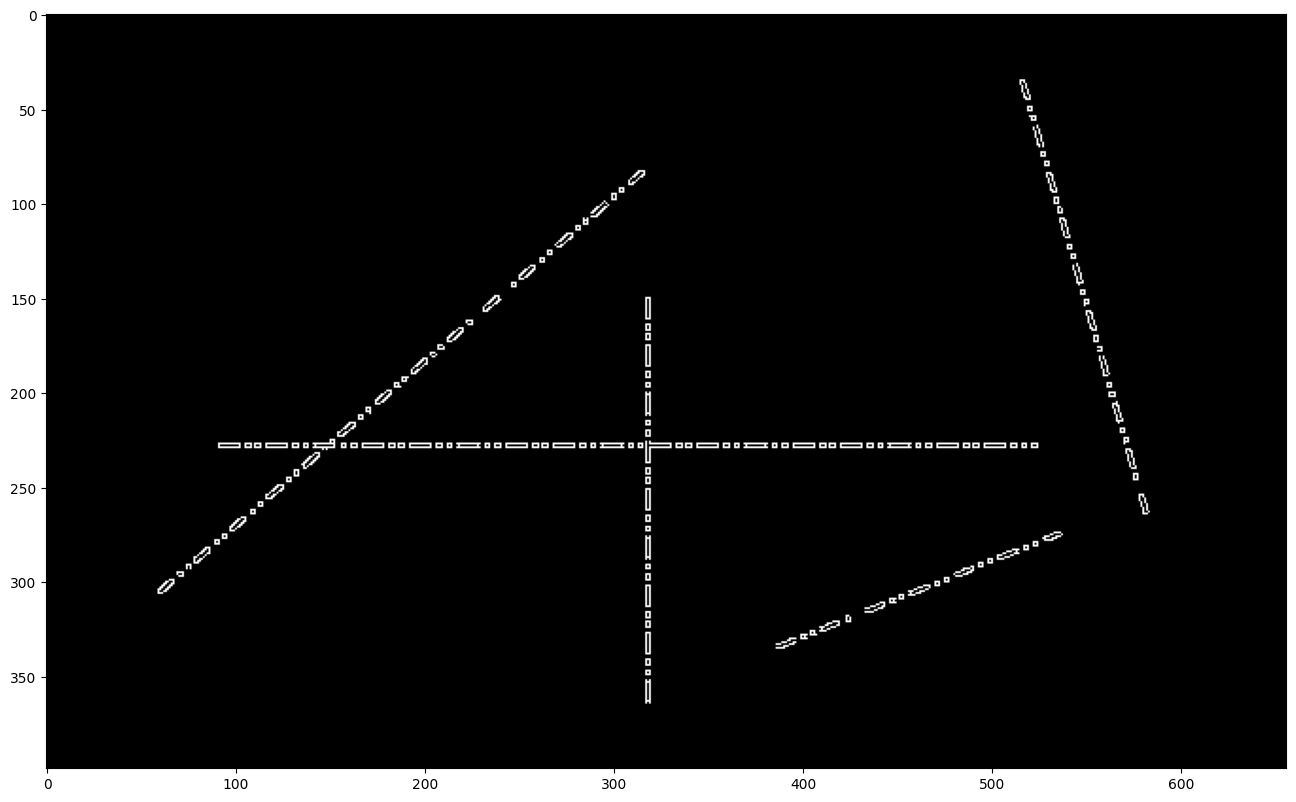

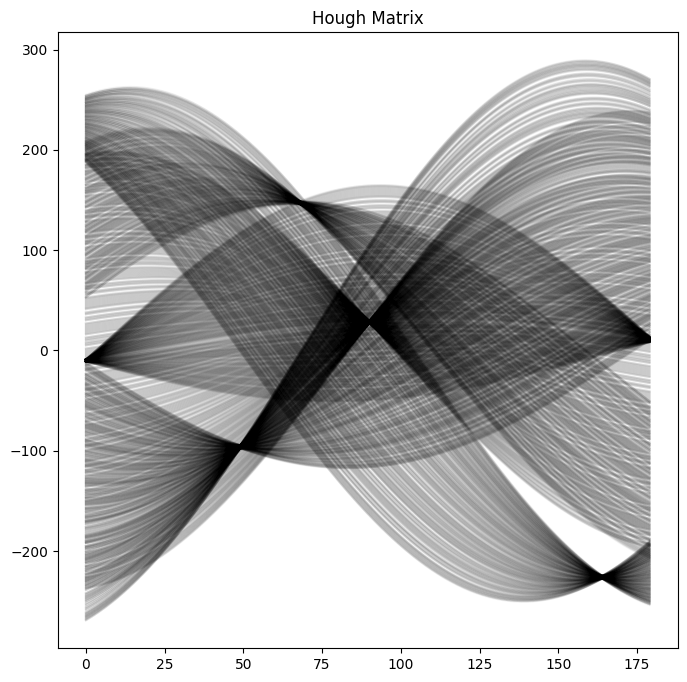

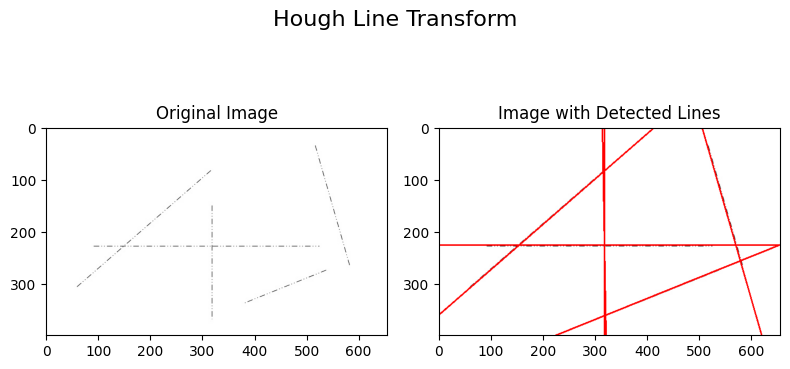

In [7]:
# 1. generated "lines1.jpg" using word to test on syntehtic image made of dots


# 2. view the edge image before the line detection (change to relevant image path)
plt.imshow(edge_detection(cv2.imread('lines1.jpg'), 140, 250))
plt.show()

# comment/uncomment to see different images
straight_lines('lines1.jpg', 1, 1, 50, True, True)
# straight_lines('Crosswalk.jpg', 1, 15, 150, True, True))
# straight_lines('linesOnTheRoadGray.jpg', 1, 15, 80, True, True))
# straight_lines('sudoku.jpg', 1, 15, 200, True, True))
print()

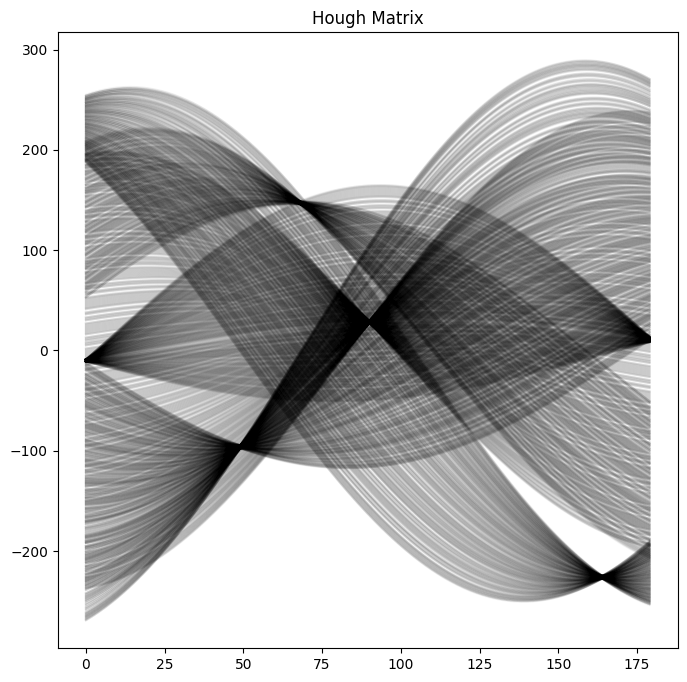

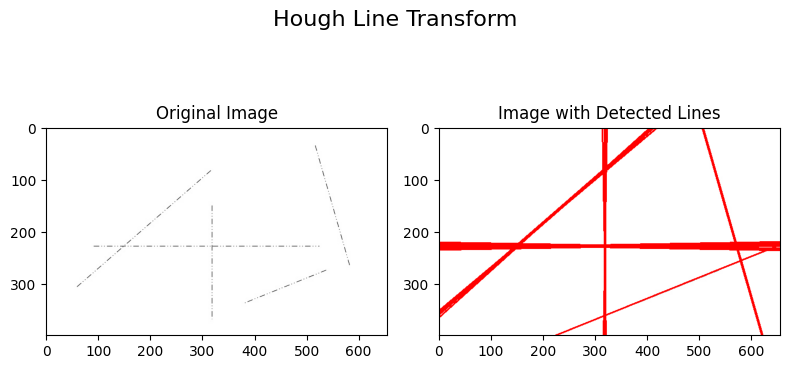

num lines : 27


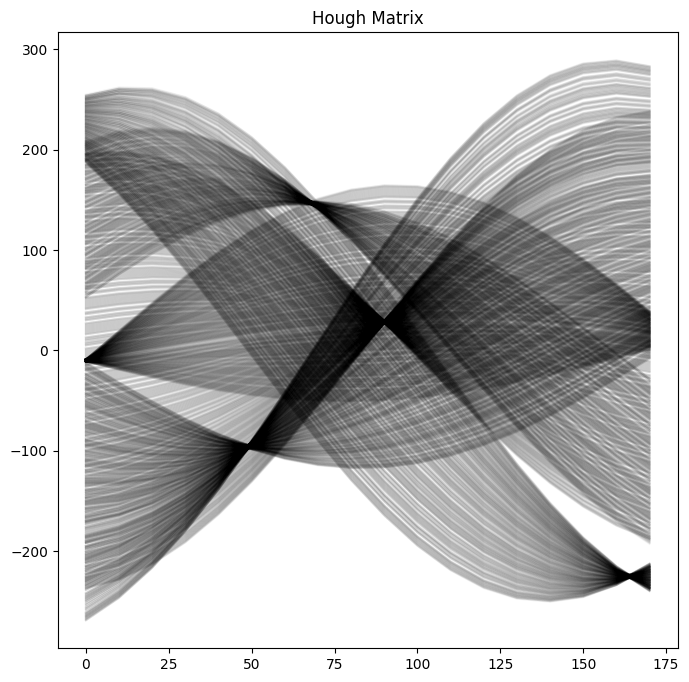

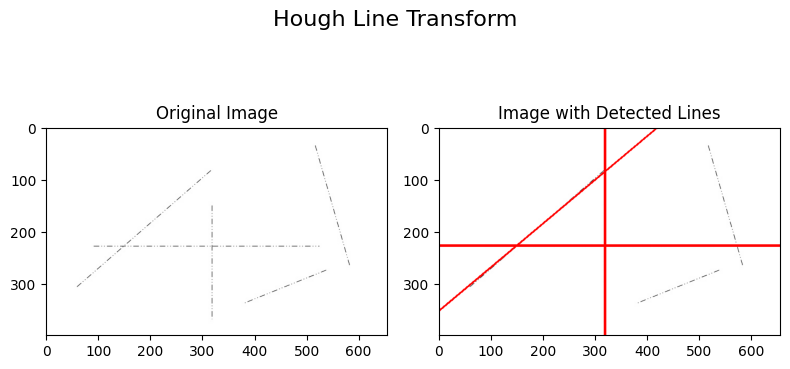

num lines : 7


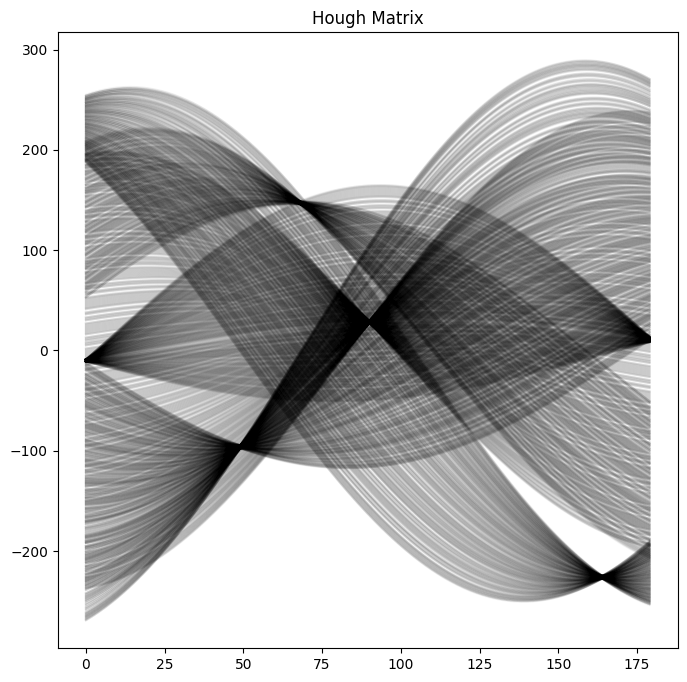

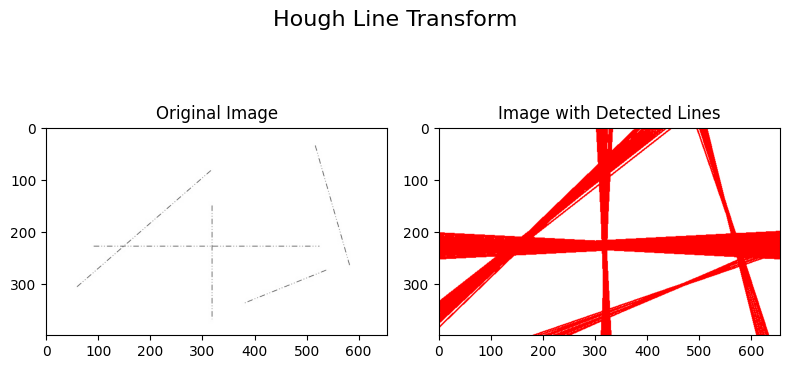

num lines : 87


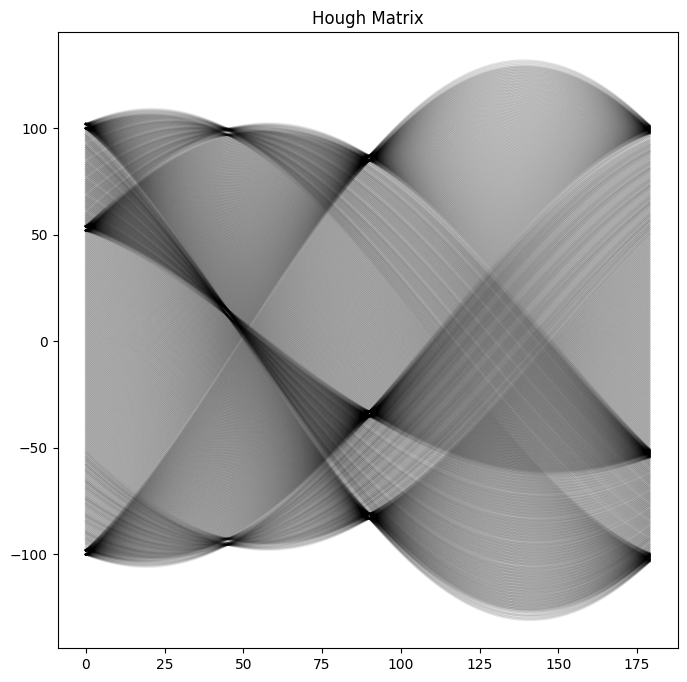

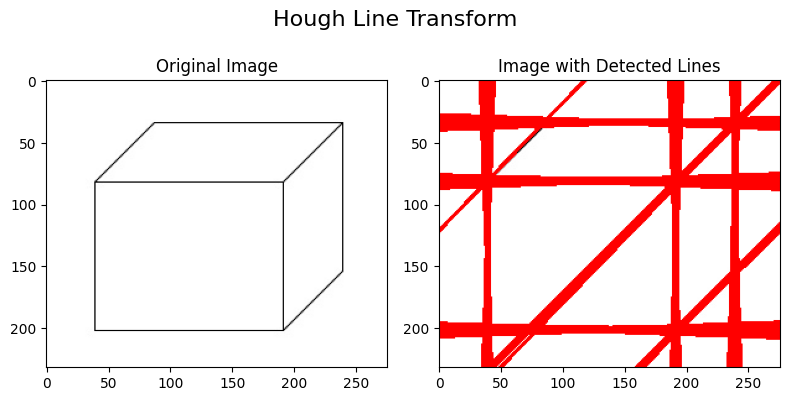

num lines : 89


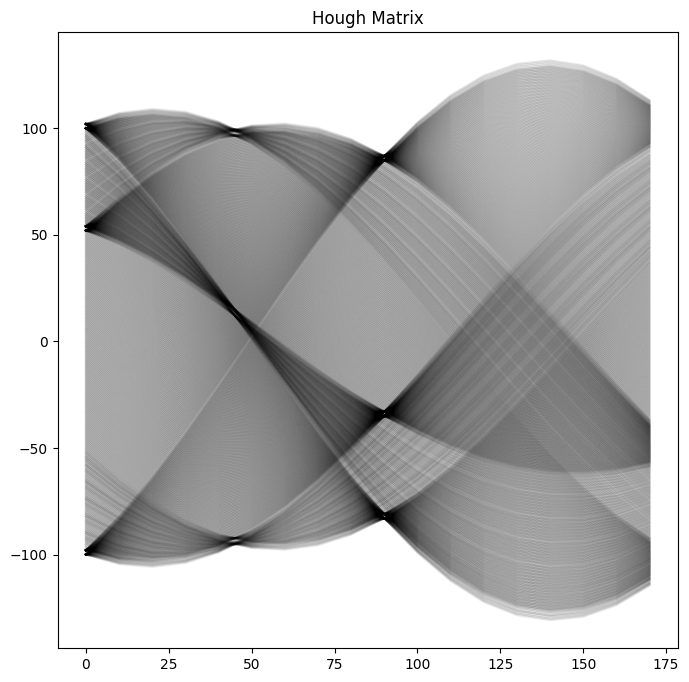

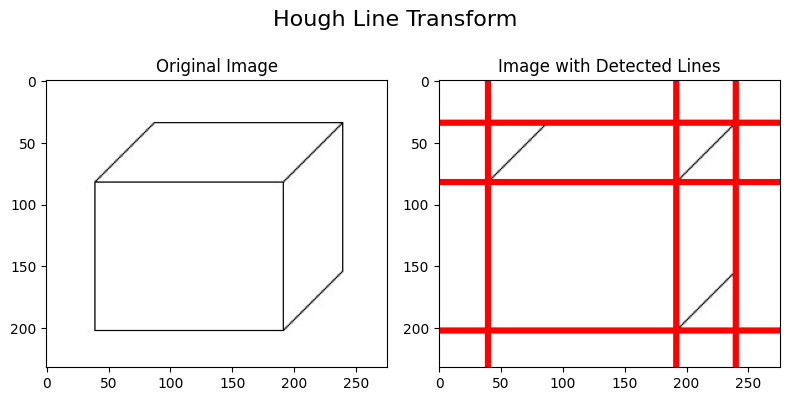

num lines : 12


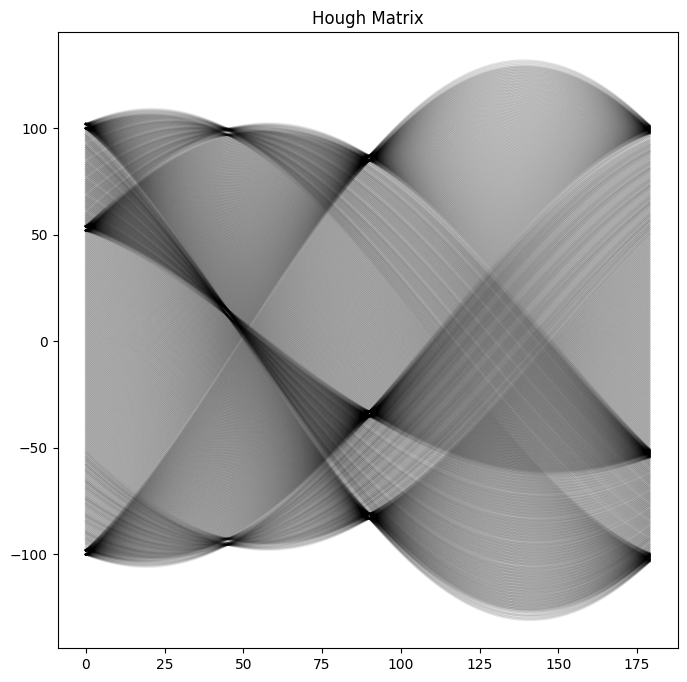

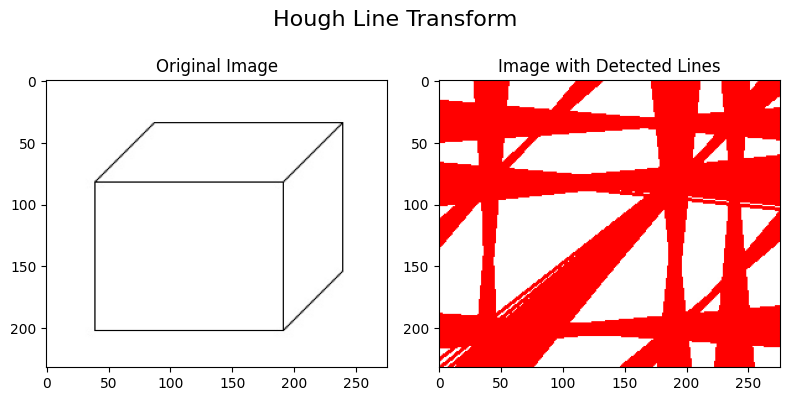

num lines : 278


In [8]:
# 3. as theta resolution increases, the number of lines increases, and the line directions are more accurate. 
#   this is because the theta resolution is the number of values in the theta axis, meaning more line slopes are checked.
#   this can lead to multiple lines for the same line, as the line can be detected in multiple slopes.
#   decreasing the theta resolution can lead to less lines, and sometimes to no lines at all, as the line slope is not detected.
#   this is also resource consuming, as the number of lines increases, the time to calculate the hough matrix increases.

#   The rho resolution is the number of values in the rho axis, as it increases, the number of lines increases as well.


print("num lines :",len(straight_lines('lines1.jpg', 1, 1, 100, True)))
print("num lines :",len(straight_lines('lines1.jpg', 1, 10, 100, True)))
print("num lines :",len(straight_lines('lines1.jpg', 3, 1, 100, True)))

print("num lines :",len(straight_lines('cube1.jpg', 1, 1, 50, True)))
print("num lines :",len(straight_lines('cube1.jpg', 1, 10, 50, True)))
print("num lines :",len(straight_lines('cube1.jpg', 2, 1, 50, True)))


## <span style="color:blue">Section B: Patch Matching
**In this part you will match intrest points between two images.**
    
    
There are two functions between vectors $v$ and $u$ that you will consider:\
a. Distance: Sum of Square Distance (SSD). That is,  $SSD(u,v)=(u-v)\cdot(u-v)$.\
b. Similarity: Normalized Cross Correlation (NCC). That is,  $NCC(u,v)={u\cdot v \over ||u||||v||}$.


The patch descriptor:
1. A vector with the pixels' grey level.
2. An histogram (30 bins) of the pixels' grey level.
3. A vector with the pixels' strength gradient.
4. An histogram (30 bins) of the pixels' strength of gradient. 


In [9]:
#Implement the following functions:

# Input: two vectors
# Output distance (scalar) between two patches

def  SSD(patch_descr_1, patch_descr_2) ()
...

# Input: two vectors
# Output normalized cross correlation  (scalar) between two patches

def NCC(patch_descr_1, patch_descr_2) ()
..

# Output a descriptor vector 
# im is an image, p is a pixel, size is the patch size.
# You can use the histogram function of open cv or numpy

def patch_from_im(im,p,size) ()
...

def hist_patch_im(im,p,size) ()
...

def  gradient(im,p,size) ()
...

def  hist_gradient(im,p,size) ()
...

SyntaxError: expected ':' (451799066.py, line 6)

**Apply and answer**


1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


2. Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.
    * Choose a fixed scale and use it to define a patch around each corner.
    * To display the matching, use the function cv2.hconcat([im1, im2]), which concatenates two images horizontally, and then draw lines as described in the previous section.


3. Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).


4. Study the ratio for matching between the best and the second best match. 
   * You can use NCC or SSD on the desriptor of your choice.
   * You can use without (2) or with (3) the $y$-coordinate constraint.
   * **Present** examples that demonstrate the effectiveness of using the ratio.


5. Study the differences between the different descriptors and also the use of SSD or NCC. 
   * **Present**  examples that demonstrate your findings.


6. Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   **Answer**\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?


7. In which regions of the scene were most of the reliable matches found?



**Implementation details**

You can compute the NCC or SSD patch by patch. This will probably takes longer than using matrix multiplications of numpy.

Using matrices:
1. Generate a 1D vector from each descriptor.


2. Generate a matrix $M_1$:  rows  are  the descriptors of img1.


3. Generate a matrix $M_2$:  columns  are  the descriptors of img2.


4. $M=np.matmul(M_1,M_2)$\
   * what is the value in $M(i,j)$?


5. Think of how to normalize the set of patches, if you need.
   * You can consider using the function np.diag(np.diag(matrix)) as part of your solution.
    
    

## <span style="color:blue">Section C

In this part you will compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving. 
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   
  
4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped. 
    * Display the disparity as an image. 
   

4. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.


**Implementation**\
You can implement the computation of the similarity and the disparity directly by an exhaustive search. You can also use the idea from Part B. A more efficeint and elegant way is described below. You are welcome to try, but you do not have to.


General idea for the **vectorized solution** (you will need to fill in the gaps):
* Let $w$ and $h$ we the width and the height of the image respectively.
* First assume that the patch size is $1\times s_y$.
* Given two $1\times w$ rows, $r_1$ and $r_2$ which are corresponding rows of the two images. Compute the $w\times w$ matrix $R12=r_1^T r_2$. The values $R12(i,j)$ consists of the product of two pixels $r_1(i)\cdot r_2(j)$.
* Convolve $R12$ with the $s_y\times s_y$ identity matrix, $I_{s_y}$ : $Corr=I_{s_y}*R12$. The value $Corr(i,j)$ is the correlation of the $s_y$ 1D neighborhood of $r_1(i)$ and  $r_2(j)$.
* Think about how to normalize this correlation using the same idea. Hint, use the computation of $I_{s_y}*(r_1^Tr_1)$ and $I_{s_y}*(r_2^Tr_2)$.
* For a general patch size, $s_x\times s_y$, define $R$ to be 3D matrix of size $h\times w\times s_x$ and use 3D mask for the convolution.
* Up to here, we considered each row seperately, hence we need to loop over all rows of the images. There is a way to do it without looping, but not in this assignemnt :)
